# Section 3.1 Feed-forward Neural Network

In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Input, Dropout

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

In [3]:
# Load data
X_train = pd.read_csv('Data/Splitting/Generic/X_train.csv')
y_train_FSO = pd.read_csv('Data/Splitting/Generic/y_train_FSO.csv')
y_train_RF = pd.read_csv('Data/Splitting/Generic/y_train_RF.csv')

X_val = pd.read_csv('Data/Splitting/Generic/X_val.csv')
y_val_FSO = pd.read_csv('Data/Splitting/Generic/y_val_FSO.csv')
y_val_RF = pd.read_csv('Data/Splitting/Generic/y_val_RF.csv')

In [4]:
# One-hot encoding categorical features
categorical_columns = ['Hour', 'Freq', 'SC']
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(X_train[categorical_columns])

# Drop original categorical columns and add encoded columns
X_train = X_train.drop(categorical_columns, axis=1)
X_train = np.concatenate([X_train, encoded_cats], axis=1)

# Apply the same encoding to validation data
encoded_cats_val = encoder.transform(X_val[categorical_columns])
X_val = X_val.drop(categorical_columns, axis=1)
X_val = np.concatenate([X_val, encoded_cats_val], axis=1)

In [5]:
# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## ANN Model

In [6]:
def rmse(y_true, y_pred):
    '''
    Calculate the Root Mean Squared Error (RMSE).
    '''
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [7]:
def r2_score(y_true, y_pred):
    '''
    Calculate the R² score.
    '''
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

In [8]:
def build_ann_model(X_train, y_train, X_val, y_val, units, num_layers, 
                    learning_rate=0.001, activation='relu', epochs=50):
    """
    Build, train, and evaluate an Artificial Neural Network (ANN) model.

    Parameters:
    - X_train: Training feature set
    - y_train: Training target set
    - X_val: Validation feature set
    - y_val: Validation target set
    - units: List of units for each hidden layer
    - num_layers: Number of hidden layers
    - learning_rate: Learning rate for the optimizer (default: 0.001)
    - activation: Activation function for hidden layers (default: 'relu')
    - epochs: Number of epochs for training (default: 50)

    Returns:
    - model: Trained Keras model
    - final_metrics: Dictionary containing final training and validation metrics
    - history: Full training history as a dictionary
    """
    # Build the model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  # Input layer

    # Add hidden layers with specified number of units and activation
    for i in range(num_layers):
        model.add(Dense(units[i], activation=activation))
        model.add(BatchNormalization())

    # Output layer for regression (linear activation)
    model.add(Dense(1, activation='linear'))

    # Select optimizer
    optimizer = Adam(learning_rate=learning_rate)

    # Compile the model with custom metrics
    model.compile(optimizer=optimizer, loss='mse', metrics=[rmse, r2_score])

    # Train the model and capture the training history
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, 
                        validation_data=(X_val, y_val), verbose=0)

    # Extract final epoch metrics
    final_epoch = epochs - 1
    final_metrics = {
        "Training Loss": history.history['loss'][final_epoch],
        "Validation Loss": history.history['val_loss'][final_epoch],
        "Training RMSE": history.history['rmse'][final_epoch],
        "Validation RMSE": history.history['val_rmse'][final_epoch],
        "Training R²": history.history['r2_score'][final_epoch],
        "Validation R²": history.history['val_r2_score'][final_epoch]
    }

    return model, final_metrics, history.history


In [9]:
def ann_gridsearch(X_train, y_train, X_val, y_val, 
                   epochs=50,
                   layer_units=[32, 64], 
                   num_layers_options=[2, 3], 
                   activation_options=['tanh', 'sigmoid'], 
                   learning_rate_options=[0.01]):
    """
    Perform a grid search to tune hyperparameters of an ANN.

    Parameters:
    - X_train, y_train: Training dataset
    - X_val, y_val: Validation dataset
    - epochs: Number of epochs for training (default: 50)
    - layer_units: List of units per layer (e.g., [32, 64])
    - num_layers_options: List of hidden layer options (e.g., [2, 3])
    - activation_options: List of activation functions (e.g., ['tanh', 'sigmoid'])
    - learning_rate_options: List of learning rates (e.g., [0.01])

    Returns:
    - results_df: DataFrame containing performance metrics for each configuration
    - models: List of trained models
    - histories: List of training histories for visualization
    """
    results = []
    histories = []  # To store training histories for all models
    models = []     # To store trained models for saving later

    for num_layers in num_layers_options:
        # Generate all unit combinations for the given number of layers
        units_options = list(product(layer_units, repeat=num_layers))
        
        for units in units_options:
            for activation in activation_options:
                for learning_rate in learning_rate_options:
                    print(f"\nRunning model with Units: {units}, Layers: {num_layers}, "
                          f"Activation: {activation}, LR: {learning_rate}")
                        
                    # Build and train the model
                    model, final_metrics, history = build_ann_model(
                        X_train, y_train, X_val, y_val,
                        units=units, num_layers=num_layers,
                        learning_rate=learning_rate, activation=activation, epochs=epochs
                    )
                        
                    # Store the trained model
                    models.append(model)
                        
                    # Store the training history
                    histories.append({
                        'history': history,
                        'Model Name': f"ANN-{units}-{activation}-{learning_rate}"
                    })
                        
                    # Store the results
                    result = {
                        'Model Name': f"ANN-{units}-{activation}-{learning_rate}",
                        'Units': units,
                        'Layers': num_layers,
                        'Activation': activation,
                        'Learning Rate': learning_rate,
                        'Training Loss': final_metrics["Training Loss"],
                        'Validation Loss': final_metrics["Validation Loss"],
                        'Training RMSE': final_metrics["Training RMSE"],
                        'Validation RMSE': final_metrics["Validation RMSE"],
                        'Training R²': final_metrics["Training R²"],
                        'Validation R²': final_metrics["Validation R²"]
                    }
                    results.append(result)

    # Convert results to a DataFrame for easy display
    results_df = pd.DataFrame(results)
     
    print("\nSummary of All Model Configurations:")
    try:
        display(results_df)  # For Jupyter Notebooks
    except NameError:
        print(results_df)  # For other environments
    
    return results_df, models, histories

In [10]:
def plot_best_models(results_df, histories, top_num=3):
    """
    Plot the training and validation metrics for the top models.

    Parameters:
    - results_df: DataFrame containing model configurations and their performance metrics.
    - histories: List of dictionaries with training history and model names.
    - top_num: Number of top models to plot based on Validation R² and Validation RMSE.

    Returns:
    - None. Displays the plots for the top models.
    """
    # Sort by highest Validation R² and lowest Validation RMSE
    top_models = results_df.sort_values(by=['Validation R²', 'Validation RMSE'], 
                                        ascending=[False, True]).head(top_num)
    
    print(f"\nTop {top_num} Model Configurations with Highest Validation R² and Lowest Validation RMSE:")
    try:
        display(top_models)  # For Jupyter Notebooks
    except NameError:
        print(top_models)  # For non-Jupyter environments
    
    # Create subplots for metric curves
    num_top_models = len(top_models)
    fig, axes = plt.subplots(num_top_models, 1, figsize=(12, num_top_models * 4))
    
    # Handle single subplot case
    if num_top_models == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, top_models.iterrows()):
        # Find the matching history for the current top model
        matching_history = next(
            (h['history'] for h in histories if h['Model Name'] == row['Model Name']),
            None
        )
        
        if matching_history is None:
            print(f"No matching history found for model: {row['Model Name']}")
            continue
        
        # Plot metrics
        ax.plot(matching_history['loss'], label='Training Loss', linestyle='--')
        ax.plot(matching_history['val_loss'], label='Validation Loss', linestyle='-')
        ax.plot(matching_history['rmse'], label='Training RMSE', linestyle='--')
        ax.plot(matching_history['val_rmse'], label='Validation RMSE', linestyle='-')
        ax.plot(matching_history['r2_score'], label='Training R²', linestyle='--')
        ax.plot(matching_history['val_r2_score'], label='Validation R²', linestyle='-')
        ax.set_title(f"Metrics for Top Model: {row['Model Name']}", fontsize=14)
        ax.set_xlabel('Epochs', fontsize=12)
        ax.set_ylabel('Metrics', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()


In [16]:
def save_best_model(results_df, models, histories, nntype, channel):
    """
    Save the best model based on Validation R² and RMSE.

    Parameters:
    - results_df: DataFrame containing model configurations and their performance metrics.
    - models: List of trained models corresponding to the results_df rows.
    - histories: List of training histories corresponding to the models.
    - nntype: A string indicating the type of neural network (e.g., 'ANN', 'CNN').

    Returns:
    - model_save_path: The file path where the best model was saved.
    """
    # Sort by highest Validation R² and lowest Validation RMSE
    top_model_index = results_df.sort_values(
        by=['Validation R²', 'Validation RMSE'], ascending=[False, True]
    ).index[0]  # Get the index of the best model
    
    # Retrieve the best model and its details
    best_model = models[top_model_index]
    best_result = results_df.iloc[top_model_index]
    best_history = histories[top_model_index]['history']
    
    # Ensure the directory for saved models exists
    os.makedirs("saved_models", exist_ok=True)
    
    # Save the best model
    model_save_path = f"saved_models/{channel}_best_{nntype}_model.h5"
    save_model(best_model, model_save_path)
    print(f"\nBest {nntype} model saved to: {model_save_path}")
    
    # Print details of the best model
    print(f"\nBest {nntype} Model Details:")
    print(best_result)
    
    return model_save_path


In [21]:
# Define hyperparameters for the ANN grid search
layer_units = [32, 64, 128, 256]
num_layers_options = [2, 3]
activation_options = ['relu', 'tanh', 'sigmoid']
learning_rate_options = [0.01, 0.001]

In [13]:
# Run grid search for ANN model targeting FSO attenuation
ann_FSO_results, ann_FSO_models, ann_FSO_histories = ann_gridsearch(
    X_train=X_train, 
    y_train=y_train_FSO, 
    X_val=X_val, 
    y_val=y_val_FSO, 
    epochs=100, 
    layer_units=layer_units, 
    num_layers_options=num_layers_options,
    activation_options=activation_options, 
    learning_rate_options=learning_rate_options
)


Running model with Units: (32, 32), Layers: 2, Activation: relu, LR: 0.01

Running model with Units: (32, 32), Layers: 2, Activation: relu, LR: 0.001

Running model with Units: (32, 32), Layers: 2, Activation: tanh, LR: 0.01

Running model with Units: (32, 32), Layers: 2, Activation: tanh, LR: 0.001

Running model with Units: (32, 32), Layers: 2, Activation: sigmoid, LR: 0.01

Running model with Units: (32, 32), Layers: 2, Activation: sigmoid, LR: 0.001

Running model with Units: (32, 64), Layers: 2, Activation: relu, LR: 0.01

Running model with Units: (32, 64), Layers: 2, Activation: relu, LR: 0.001

Running model with Units: (32, 64), Layers: 2, Activation: tanh, LR: 0.01

Running model with Units: (32, 64), Layers: 2, Activation: tanh, LR: 0.001

Running model with Units: (32, 64), Layers: 2, Activation: sigmoid, LR: 0.01

Running model with Units: (32, 64), Layers: 2, Activation: sigmoid, LR: 0.001

Running model with Units: (32, 128), Layers: 2, Activation: relu, LR: 0.01

Runni


Running model with Units: (32, 32, 64), Layers: 3, Activation: sigmoid, LR: 0.01

Running model with Units: (32, 32, 64), Layers: 3, Activation: sigmoid, LR: 0.001

Running model with Units: (32, 32, 128), Layers: 3, Activation: relu, LR: 0.01

Running model with Units: (32, 32, 128), Layers: 3, Activation: relu, LR: 0.001

Running model with Units: (32, 32, 128), Layers: 3, Activation: tanh, LR: 0.01

Running model with Units: (32, 32, 128), Layers: 3, Activation: tanh, LR: 0.001

Running model with Units: (32, 32, 128), Layers: 3, Activation: sigmoid, LR: 0.01

Running model with Units: (32, 32, 128), Layers: 3, Activation: sigmoid, LR: 0.001

Running model with Units: (32, 32, 256), Layers: 3, Activation: relu, LR: 0.01

Running model with Units: (32, 32, 256), Layers: 3, Activation: relu, LR: 0.001

Running model with Units: (32, 32, 256), Layers: 3, Activation: tanh, LR: 0.01

Running model with Units: (32, 32, 256), Layers: 3, Activation: tanh, LR: 0.001

Running model with Unit


Running model with Units: (64, 32, 128), Layers: 3, Activation: tanh, LR: 0.001

Running model with Units: (64, 32, 128), Layers: 3, Activation: sigmoid, LR: 0.01

Running model with Units: (64, 32, 128), Layers: 3, Activation: sigmoid, LR: 0.001

Running model with Units: (64, 32, 256), Layers: 3, Activation: relu, LR: 0.01

Running model with Units: (64, 32, 256), Layers: 3, Activation: relu, LR: 0.001

Running model with Units: (64, 32, 256), Layers: 3, Activation: tanh, LR: 0.01

Running model with Units: (64, 32, 256), Layers: 3, Activation: tanh, LR: 0.001

Running model with Units: (64, 32, 256), Layers: 3, Activation: sigmoid, LR: 0.01

Running model with Units: (64, 32, 256), Layers: 3, Activation: sigmoid, LR: 0.001

Running model with Units: (64, 64, 32), Layers: 3, Activation: relu, LR: 0.01

Running model with Units: (64, 64, 32), Layers: 3, Activation: relu, LR: 0.001

Running model with Units: (64, 64, 32), Layers: 3, Activation: tanh, LR: 0.01

Running model with Units


Running model with Units: (128, 32, 256), Layers: 3, Activation: tanh, LR: 0.01

Running model with Units: (128, 32, 256), Layers: 3, Activation: tanh, LR: 0.001

Running model with Units: (128, 32, 256), Layers: 3, Activation: sigmoid, LR: 0.01

Running model with Units: (128, 32, 256), Layers: 3, Activation: sigmoid, LR: 0.001

Running model with Units: (128, 64, 32), Layers: 3, Activation: relu, LR: 0.01

Running model with Units: (128, 64, 32), Layers: 3, Activation: relu, LR: 0.001

Running model with Units: (128, 64, 32), Layers: 3, Activation: tanh, LR: 0.01

Running model with Units: (128, 64, 32), Layers: 3, Activation: tanh, LR: 0.001

Running model with Units: (128, 64, 32), Layers: 3, Activation: sigmoid, LR: 0.01

Running model with Units: (128, 64, 32), Layers: 3, Activation: sigmoid, LR: 0.001

Running model with Units: (128, 64, 64), Layers: 3, Activation: relu, LR: 0.01

Running model with Units: (128, 64, 64), Layers: 3, Activation: relu, LR: 0.001

Running model wit


Running model with Units: (256, 64, 32), Layers: 3, Activation: relu, LR: 0.01

Running model with Units: (256, 64, 32), Layers: 3, Activation: relu, LR: 0.001

Running model with Units: (256, 64, 32), Layers: 3, Activation: tanh, LR: 0.01

Running model with Units: (256, 64, 32), Layers: 3, Activation: tanh, LR: 0.001

Running model with Units: (256, 64, 32), Layers: 3, Activation: sigmoid, LR: 0.01

Running model with Units: (256, 64, 32), Layers: 3, Activation: sigmoid, LR: 0.001

Running model with Units: (256, 64, 64), Layers: 3, Activation: relu, LR: 0.01

Running model with Units: (256, 64, 64), Layers: 3, Activation: relu, LR: 0.001

Running model with Units: (256, 64, 64), Layers: 3, Activation: tanh, LR: 0.01

Running model with Units: (256, 64, 64), Layers: 3, Activation: tanh, LR: 0.001

Running model with Units: (256, 64, 64), Layers: 3, Activation: sigmoid, LR: 0.01

Running model with Units: (256, 64, 64), Layers: 3, Activation: sigmoid, LR: 0.001

Running model with Un

,Model Name,Units,Layers,Activation,Learning Rate,Training Loss,Validation Loss,Training RMSE,Validation RMSE,Training R²,Validation R²
0,"ANN-(32, 32)-relu-0.01","(32, 32)",2,relu,0.010,2.311295,1.834677,1.467192,1.314211,0.830000,0.859685
1,"ANN-(32, 32)-relu-0.001","(32, 32)",2,relu,0.001,2.209323,1.572905,1.438782,1.211933,0.837855,0.883239
2,"ANN-(32, 32)-tanh-0.01","(32, 32)",2,tanh,0.010,3.280865,2.722446,1.752297,1.597270,0.763092,0.796020
3,"ANN-(32, 32)-tanh-0.001","(32, 32)",2,tanh,0.001,2.082311,1.981396,1.390370,1.258495,0.846293,0.869272
4,"ANN-(32, 32)-sigmoid-0.01","(32, 32)",2,sigmoid,0.010,2.387836,2.174411,1.493788,1.406266,0.824575,0.842593
...,...,...,...,...,...,...,...,...,...,...,...
475,"ANN-(256, 256, 256)-relu-0.001","(256, 256, 256)",3,relu,0.001,1.105283,0.910724,0.999762,0.920642,0.914965,0.931173
476,"ANN-(256, 256, 256)-tanh-0.01","(256, 256, 256)",3,tanh,0.010,7.645931,8.383203,2.699133,2.817873,0.463862,0.377063
477,"ANN-(256, 256, 256)-tanh-0.001","(256, 256, 256)",3,tanh,0.001,1.087970,1.257077,0.983544,1.047569,0.916284,0.907541
478,"ANN-(256, 256, 256)-sigmoid-0.01","(256, 256, 256)",3,sigmoid,0.010,5.316747,4.577266,2.238558,2.077044,0.625639,0.659236



Top 5 Model Configurations with Highest Validation R² and Lowest Validation RMSE:


,Model Name,Units,Layers,Activation,Learning Rate,Training Loss,Validation Loss,Training RMSE,Validation RMSE,Training R²,Validation R²
449,"ANN-(256, 128, 128)-sigmoid-0.001","(256, 128, 128)",3,sigmoid,0.001,1.121879,0.819211,1.004974,0.867777,0.913615,0.938353
383,"ANN-(128, 256, 256)-sigmoid-0.001","(128, 256, 256)",3,sigmoid,0.001,1.121703,0.826131,1.002232,0.864109,0.912962,0.938339
479,"ANN-(256, 256, 256)-sigmoid-0.001","(256, 256, 256)",3,sigmoid,0.001,1.063850,0.834387,0.973621,0.873428,0.918627,0.937473
377,"ANN-(128, 256, 128)-sigmoid-0.001","(128, 256, 128)",3,sigmoid,0.001,1.116208,0.840361,1.001263,0.876498,0.915874,0.936956
359,"ANN-(128, 128, 256)-sigmoid-0.001","(128, 128, 256)",3,sigmoid,0.001,1.161540,0.831416,1.027132,0.872572,0.910748,0.936953


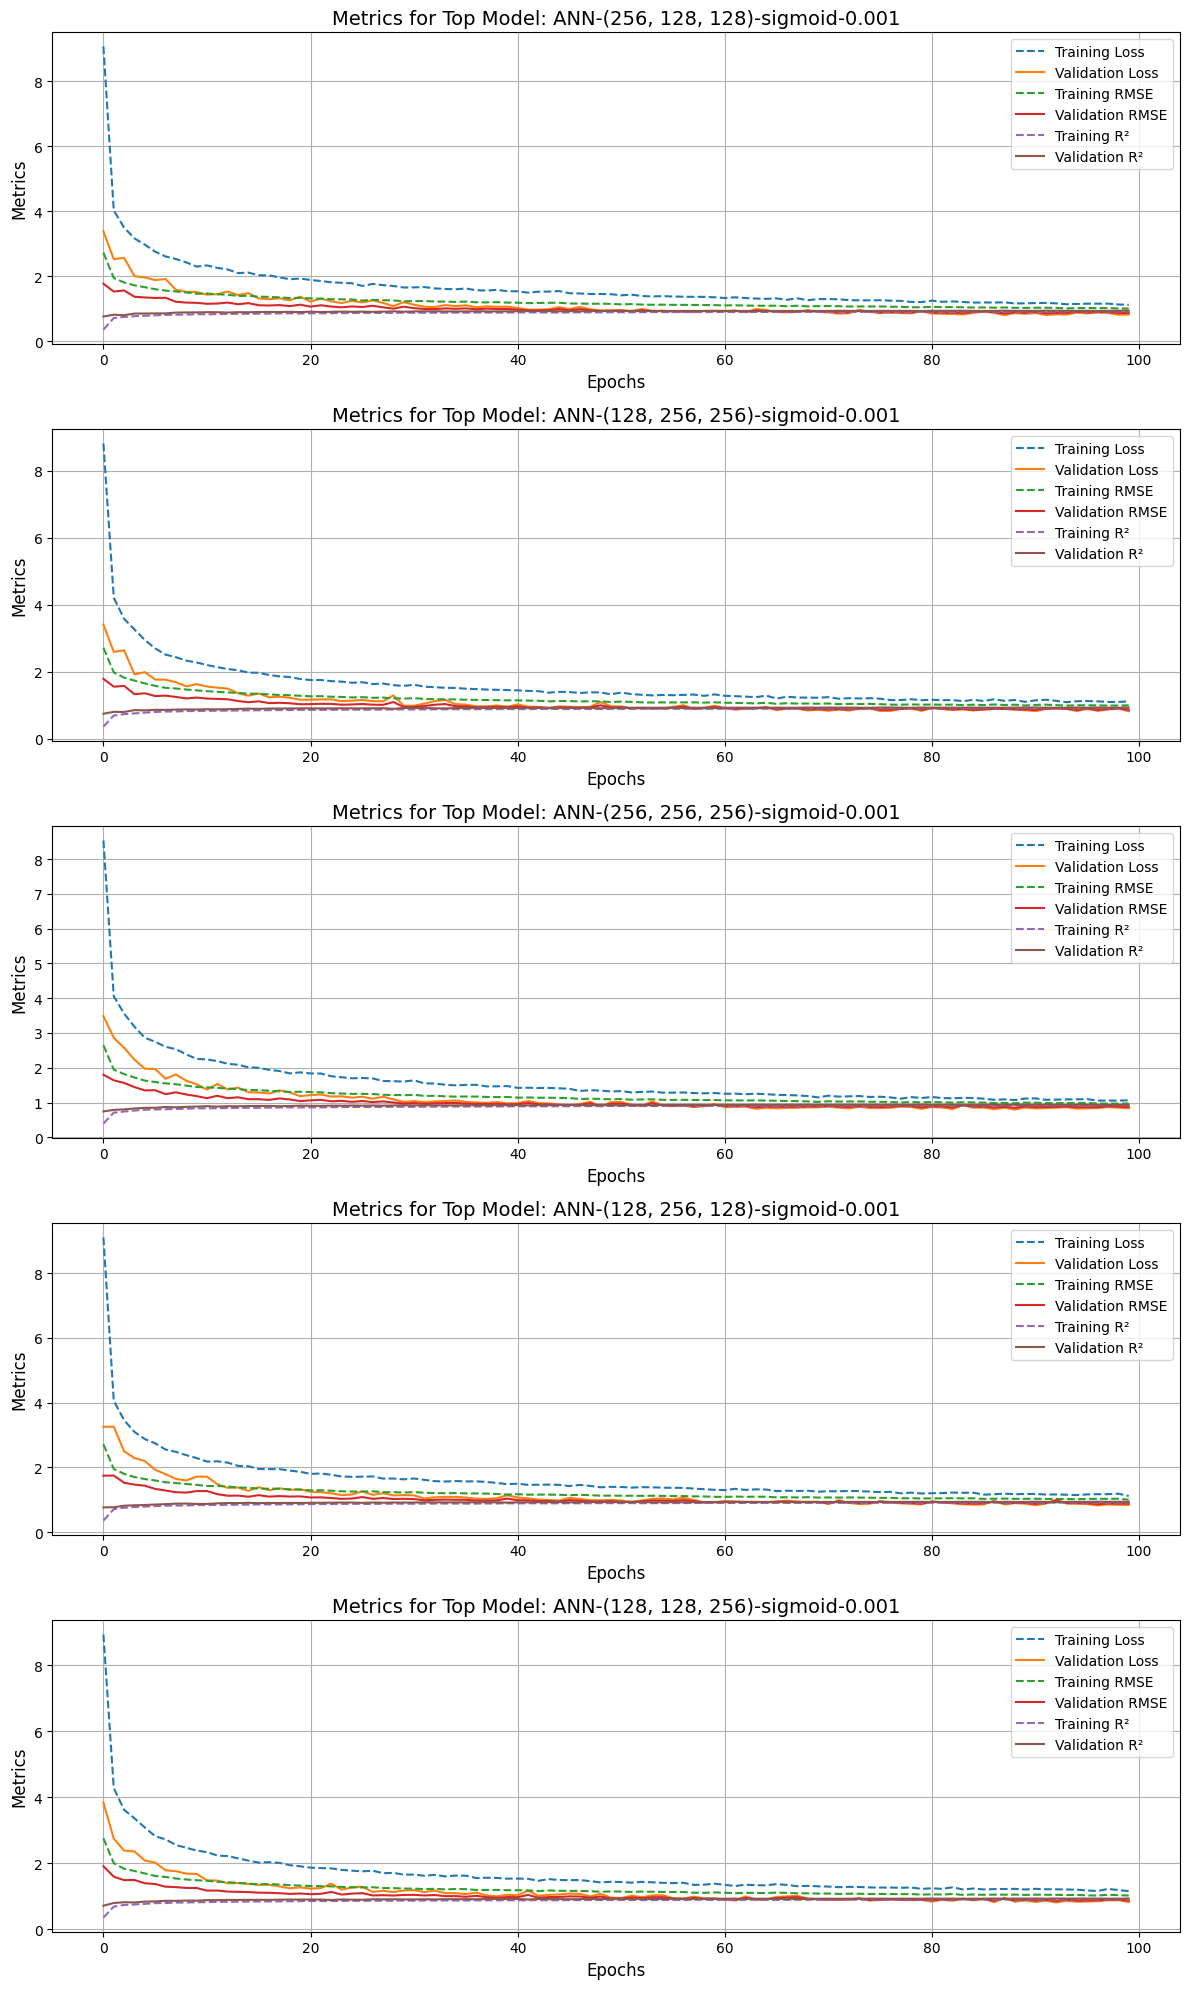

In [14]:
# Plot metrics for the top 5 models
plot_best_models(ann_FSO_results, ann_FSO_histories, top_num=5)

In [18]:
# Save the best ANN model for FSO attenuation
save_best_model(ann_FSO_results, ann_FSO_models, ann_FSO_histories, "ANN", "FSO")


Best ANN model saved to: saved_models/FSO_best_ANN_model.h5

Best ANN Model Details:
Model Name         ANN-(256, 128, 128)-sigmoid-0.001
Units                                (256, 128, 128)
Layers                                             3
Activation                                   sigmoid
Learning Rate                                  0.001
Training Loss                               1.121879
Validation Loss                             0.819211
Training RMSE                               1.004974
Validation RMSE                             0.867777
Training R²                                 0.913615
Validation R²                               0.938353
Name: 449, dtype: object


'saved_models/FSO_best_ANN_model.h5'

In [22]:
# Run grid search for ANN model targeting RF attenuation
ann_RF_results, ann_RF_models, ann_RF_histories = ann_gridsearch(
    X_train, y_train_RF, 
    X_val, y_val_RF, 
    epochs=100,
    layer_units=layer_units, 
    num_layers_options=num_layers_options,
    activation_options=activation_options, 
    learning_rate_options=learning_rate_options
)


Running model with Units: (32, 32), Layers: 2, Activation: relu, LR: 0.01

Running model with Units: (32, 32), Layers: 2, Activation: relu, LR: 0.001

Running model with Units: (32, 32), Layers: 2, Activation: tanh, LR: 0.01

Running model with Units: (32, 32), Layers: 2, Activation: tanh, LR: 0.001

Running model with Units: (32, 32), Layers: 2, Activation: sigmoid, LR: 0.01

Running model with Units: (32, 32), Layers: 2, Activation: sigmoid, LR: 0.001

Running model with Units: (32, 64), Layers: 2, Activation: relu, LR: 0.01

Running model with Units: (32, 64), Layers: 2, Activation: relu, LR: 0.001

Running model with Units: (32, 64), Layers: 2, Activation: tanh, LR: 0.01

Running model with Units: (32, 64), Layers: 2, Activation: tanh, LR: 0.001

Running model with Units: (32, 64), Layers: 2, Activation: sigmoid, LR: 0.01

Running model with Units: (32, 64), Layers: 2, Activation: sigmoid, LR: 0.001

Running model with Units: (32, 128), Layers: 2, Activation: relu, LR: 0.01

Runni


Running model with Units: (32, 32, 64), Layers: 3, Activation: sigmoid, LR: 0.01

Running model with Units: (32, 32, 64), Layers: 3, Activation: sigmoid, LR: 0.001

Running model with Units: (32, 32, 128), Layers: 3, Activation: relu, LR: 0.01

Running model with Units: (32, 32, 128), Layers: 3, Activation: relu, LR: 0.001

Running model with Units: (32, 32, 128), Layers: 3, Activation: tanh, LR: 0.01

Running model with Units: (32, 32, 128), Layers: 3, Activation: tanh, LR: 0.001

Running model with Units: (32, 32, 128), Layers: 3, Activation: sigmoid, LR: 0.01

Running model with Units: (32, 32, 128), Layers: 3, Activation: sigmoid, LR: 0.001

Running model with Units: (32, 32, 256), Layers: 3, Activation: relu, LR: 0.01

Running model with Units: (32, 32, 256), Layers: 3, Activation: relu, LR: 0.001

Running model with Units: (32, 32, 256), Layers: 3, Activation: tanh, LR: 0.01

Running model with Units: (32, 32, 256), Layers: 3, Activation: tanh, LR: 0.001

Running model with Unit


Running model with Units: (64, 32, 128), Layers: 3, Activation: tanh, LR: 0.001

Running model with Units: (64, 32, 128), Layers: 3, Activation: sigmoid, LR: 0.01

Running model with Units: (64, 32, 128), Layers: 3, Activation: sigmoid, LR: 0.001

Running model with Units: (64, 32, 256), Layers: 3, Activation: relu, LR: 0.01

Running model with Units: (64, 32, 256), Layers: 3, Activation: relu, LR: 0.001

Running model with Units: (64, 32, 256), Layers: 3, Activation: tanh, LR: 0.01

Running model with Units: (64, 32, 256), Layers: 3, Activation: tanh, LR: 0.001

Running model with Units: (64, 32, 256), Layers: 3, Activation: sigmoid, LR: 0.01

Running model with Units: (64, 32, 256), Layers: 3, Activation: sigmoid, LR: 0.001

Running model with Units: (64, 64, 32), Layers: 3, Activation: relu, LR: 0.01

Running model with Units: (64, 64, 32), Layers: 3, Activation: relu, LR: 0.001

Running model with Units: (64, 64, 32), Layers: 3, Activation: tanh, LR: 0.01

Running model with Units


Running model with Units: (128, 32, 256), Layers: 3, Activation: tanh, LR: 0.01

Running model with Units: (128, 32, 256), Layers: 3, Activation: tanh, LR: 0.001

Running model with Units: (128, 32, 256), Layers: 3, Activation: sigmoid, LR: 0.01

Running model with Units: (128, 32, 256), Layers: 3, Activation: sigmoid, LR: 0.001

Running model with Units: (128, 64, 32), Layers: 3, Activation: relu, LR: 0.01

Running model with Units: (128, 64, 32), Layers: 3, Activation: relu, LR: 0.001

Running model with Units: (128, 64, 32), Layers: 3, Activation: tanh, LR: 0.01

Running model with Units: (128, 64, 32), Layers: 3, Activation: tanh, LR: 0.001

Running model with Units: (128, 64, 32), Layers: 3, Activation: sigmoid, LR: 0.01

Running model with Units: (128, 64, 32), Layers: 3, Activation: sigmoid, LR: 0.001

Running model with Units: (128, 64, 64), Layers: 3, Activation: relu, LR: 0.01

Running model with Units: (128, 64, 64), Layers: 3, Activation: relu, LR: 0.001

Running model wit


Running model with Units: (256, 64, 32), Layers: 3, Activation: relu, LR: 0.01

Running model with Units: (256, 64, 32), Layers: 3, Activation: relu, LR: 0.001

Running model with Units: (256, 64, 32), Layers: 3, Activation: tanh, LR: 0.01

Running model with Units: (256, 64, 32), Layers: 3, Activation: tanh, LR: 0.001

Running model with Units: (256, 64, 32), Layers: 3, Activation: sigmoid, LR: 0.01

Running model with Units: (256, 64, 32), Layers: 3, Activation: sigmoid, LR: 0.001

Running model with Units: (256, 64, 64), Layers: 3, Activation: relu, LR: 0.01

Running model with Units: (256, 64, 64), Layers: 3, Activation: relu, LR: 0.001

Running model with Units: (256, 64, 64), Layers: 3, Activation: tanh, LR: 0.01

Running model with Units: (256, 64, 64), Layers: 3, Activation: tanh, LR: 0.001

Running model with Units: (256, 64, 64), Layers: 3, Activation: sigmoid, LR: 0.01

Running model with Units: (256, 64, 64), Layers: 3, Activation: sigmoid, LR: 0.001

Running model with Un

,Model Name,Units,Layers,Activation,Learning Rate,Training Loss,Validation Loss,Training RMSE,Validation RMSE,Training R²,Validation R²
0,"ANN-(32, 32)-relu-0.01","(32, 32)",2,relu,0.010,0.963492,0.568704,0.894785,0.650605,0.910197,0.952965
1,"ANN-(32, 32)-relu-0.001","(32, 32)",2,relu,0.001,0.879456,0.837929,0.854969,0.755130,0.918788,0.937694
2,"ANN-(32, 32)-tanh-0.01","(32, 32)",2,tanh,0.010,1.559647,1.240364,1.160225,1.018172,0.856993,0.892202
3,"ANN-(32, 32)-tanh-0.001","(32, 32)",2,tanh,0.001,0.844843,0.503729,0.835969,0.624570,0.921944,0.957380
4,"ANN-(32, 32)-sigmoid-0.01","(32, 32)",2,sigmoid,0.010,1.069732,1.541829,0.948107,0.905297,0.900782,0.904479
...,...,...,...,...,...,...,...,...,...,...,...
475,"ANN-(256, 256, 256)-relu-0.001","(256, 256, 256)",3,relu,0.001,0.599103,2.065484,0.693229,0.613106,0.943844,0.792552
476,"ANN-(256, 256, 256)-tanh-0.01","(256, 256, 256)",3,tanh,0.010,3.662363,9.017570,1.843599,2.501711,0.646894,0.248945
477,"ANN-(256, 256, 256)-tanh-0.001","(256, 256, 256)",3,tanh,0.001,0.616806,2.940471,0.711286,0.856321,0.940901,0.859846
478,"ANN-(256, 256, 256)-sigmoid-0.01","(256, 256, 256)",3,sigmoid,0.010,2.505712,2.135095,1.497341,1.352172,0.766252,0.807353



Top 5 Model Configurations with Highest Validation R² and Lowest Validation RMSE:


,Model Name,Units,Layers,Activation,Learning Rate,Training Loss,Validation Loss,Training RMSE,Validation RMSE,Training R²,Validation R²
431,"ANN-(256, 64, 256)-sigmoid-0.001","(256, 64, 256)",3,sigmoid,0.001,0.628582,0.301980,0.710779,0.491946,0.940985,0.972022
253,"ANN-(64, 128, 128)-relu-0.001","(64, 128, 128)",3,relu,0.001,0.679387,0.364246,0.743891,0.509525,0.936642,0.971789
467,"ANN-(256, 256, 64)-sigmoid-0.001","(256, 256, 64)",3,sigmoid,0.001,0.578684,0.317345,0.684743,0.491465,0.944614,0.971698
437,"ANN-(256, 128, 32)-sigmoid-0.001","(256, 128, 32)",3,sigmoid,0.001,0.600415,0.368027,0.697431,0.513625,0.942600,0.971187
413,"ANN-(256, 64, 32)-sigmoid-0.001","(256, 64, 32)",3,sigmoid,0.001,0.615513,0.320555,0.703963,0.499336,0.941051,0.970967


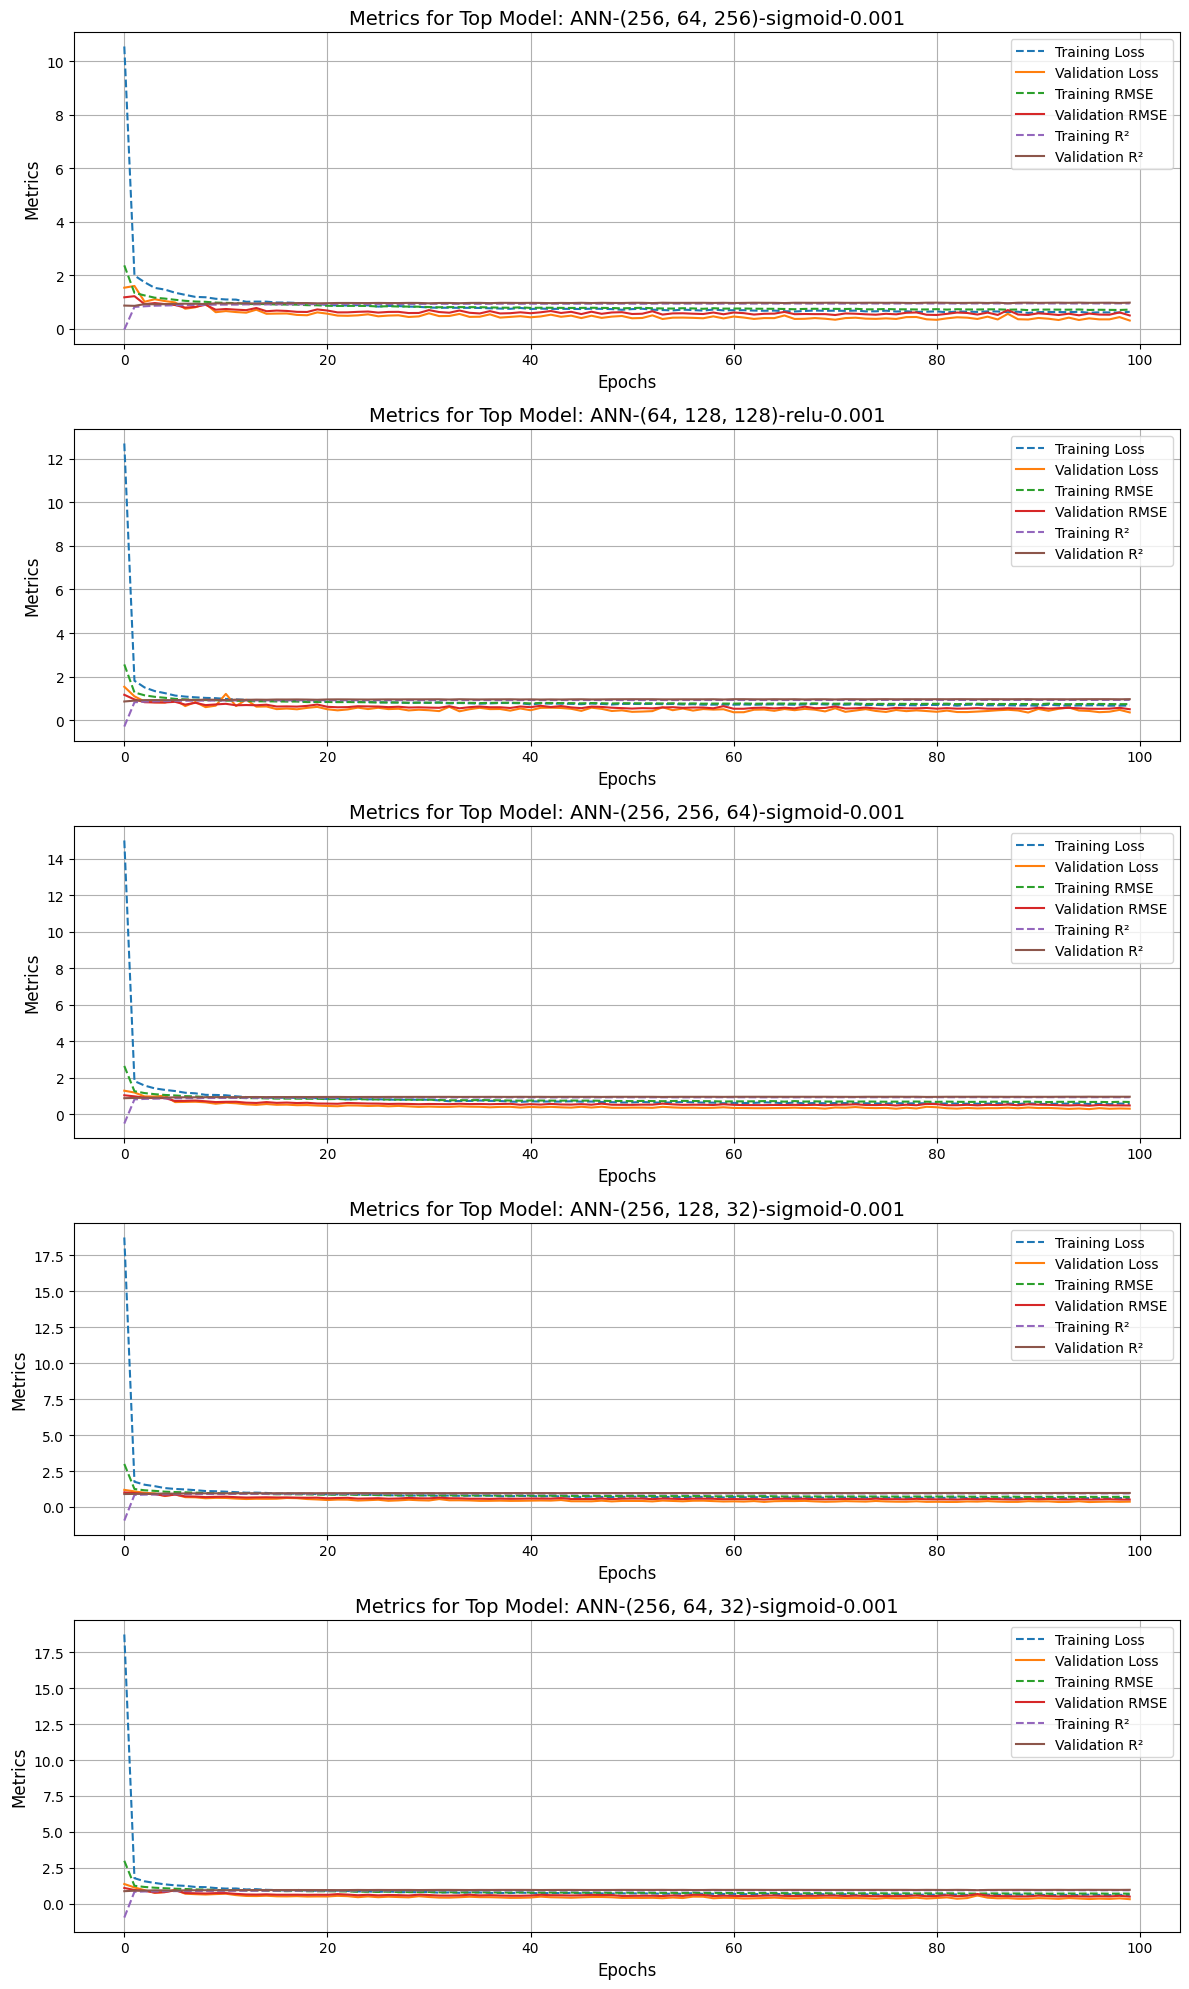

In [23]:
# Plot metrics for the top 5 models
plot_best_models(ann_RF_results, ann_RF_histories, top_num=5)

In [24]:
# Save the best ANN model for RF attenuation
save_best_model(ann_RF_results, ann_RF_models, ann_RF_histories, "ANN", "RF")


Best ANN model saved to: saved_models/RF_best_ANN_model.h5

Best ANN Model Details:
Model Name         ANN-(256, 64, 256)-sigmoid-0.001
Units                                (256, 64, 256)
Layers                                            3
Activation                                  sigmoid
Learning Rate                                 0.001
Training Loss                              0.628582
Validation Loss                             0.30198
Training RMSE                              0.710779
Validation RMSE                            0.491946
Training R²                                0.940985
Validation R²                              0.972022
Name: 431, dtype: object


'saved_models/RF_best_ANN_model.h5'